# Codebase for analysis of yeast knockout data

In the future, refactoring this code and using Classes to organize functions and data would likely be a wise move.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
from scipy.stats import norm
from matplotlib_venn import venn2, venn2_unweighted
from matplotlib.patches import FancyBboxPatch
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations   
import networkx as nx
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
import random
# personal modules
import databases as db
import kuzmin_data_2018 as data_2018
import kuzmin_data_2020 as data_2020
import enrichment as enrich

### Specify the location of various data that will be used

In [2]:
# databaQases used to biologically evaulate the results
db_dir = "./database"
db.set_base_path(db_dir)

# location of Kuzmin data
data_dir = "./"

gene_2_protein_complex = db.get_go_protein_complexes()
gene_2_go, goid_2_term = db.get_go_info()

### Specify which dataset to use
We also specify a p-value that is included in the data tables of Kuzmin et al 2020 and Kuzmin et al 2018. These were used to detect significant trigenic interactions.


In [3]:
dataset = "Kuzmin2020" # Kuzmin2020 or Kuzmin2018
p = 0.05 # p value threshold to use; 0.05 used in the paper, but we also used a value of 1 to show our results were largely insensitive to this parameter


### Load data
Because the relevant data are scattered across several tables and we want to rename, combine, and split various columns, we have all of these operation done in separate modules to keep the notebook more clean. After the tables are loaded, fitness values for single and double mutants are stored in dictionaries with names that start with `f_*`. We also load in pairwise epistasis measures since Kuzmin et al. use these to compute trigenic interactions. These are stored in dictionaries with names that follow `e_*_kuz`.

In [4]:
if dataset == "Kuzmin2018":
    kuzmin_2018_data_dir = f"{data_dir}/KuzminEtAl2018/data_files"
    kuzmin_2018_s1, kuzmin_2018_s1_digenic, kuzmin_2018_s1_trigenic = data_2018.load_kuzmin_2018_s1(kuzmin_2018_data_dir)

    costanzo_et_al_data_dir = f"{data_dir}/CostanzoEtAl2016/data_files/Data File S1. Raw genetic interaction datasets: Pair-wise interaction format"
    costanzo_data = data_2018.load_costanzo_data(costanzo_et_al_data_dir)
    #kuzmin_2020_s3, kuzmin_2020_s3_digenic = data.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
    #kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
    #kuzmin_2020_s2 = data.load_kuzmin_2020_s2(kuzmin_2020_data_dir)

    # f_i and f_j taken from costanzo, f_k taken from array allele in kuzmin 2018
    f_k_SMF = dict(zip(kuzmin_2018_s1_trigenic.array_allele_name, kuzmin_2018_s1_trigenic.array_single_mutant_fitness))

    s1 = pd.concat([costanzo_data.query_allele_name, costanzo_data.array_allele_name], axis=0)
    s2 = pd.concat([costanzo_data.query_smf, costanzo_data.array_smf], axis=0)
    df = pd.concat([s1, s2], axis=1).rename(columns={0:"allele", 1:"value"})
    df = df.drop_duplicates(subset=["allele"], keep='first').reset_index(drop=True)
    f_i_j_SMF = dict(zip(df.allele, df.value))

    # f_ij from query fitness in trigenic table
    # f_ik and f_jk from fitness digenic table
    f_ij_DMF = dict(zip(kuzmin_2018_s1_trigenic.query_allele_name, kuzmin_2018_s1_trigenic.query_single_double_mutant_fitness))
    f_ik_jk_DMF = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.query_single_double_mutant_fitness))

    #e_ik and e_jk come from the digenic portion of the Kuzmin 2018 S1 table
    e_ik_jk_DMF = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.raw_interaction_score_epsilon))

    f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz = data_2018.consolidate_fitnesses_across_2018_tables(kuzmin_2018_s1_trigenic,
                                                                                                        f_k_SMF,
                                                                                                        f_i_j_SMF,
                                                                                                        f_ij_DMF,
                                                                                                        f_ik_jk_DMF,
                                                                                                        e_ik_jk_DMF)
                                                            
    df = kuzmin_2018_s1_trigenic

if dataset == "Kuzmin2020":
    kuzmin_2020_data_dir = f"{data_dir}/KuzminEtAl2020"
    kuzmin_2020_s1, kuzmin_2020_s1_digenic, kuzmin_2020_s1_trigenic = data_2020.load_kuzmin_2020_s1(kuzmin_2020_data_dir)
    kuzmin_2020_s3, kuzmin_2020_s3_digenic = data_2020.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
    kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data_2020.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
    kuzmin_2020_s2 = data_2020.load_kuzmin_2020_s2(kuzmin_2020_data_dir)
    kuzmin_2020_s10 = data_2020.load_kuzmin_2020_s10(kuzmin_2020_data_dir)

    print(kuzmin_2020_s1.combined_mutant_type.value_counts())
    print(kuzmin_2020_s2.combined_mutant_type.value_counts())

    kuzmin_2020_s1_dblMutFit = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.double_triple_mutant_fitness))
    kuzmin_2020_s1_epsilon = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.raw_interaction_score_epsilon))
    kuzmin_2020_s1_epsilon_pvals = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.pval))
    kuzmin_2020_s1_singMutFit = dict(zip(kuzmin_2020_s1.array_allele_name, kuzmin_2020_s1.array_single_mutant_fitness))

    kuzmin_2020_s3_singMutFit = dict(zip(kuzmin_2020_s3.array_allele_name, kuzmin_2020_s3.array_single_mutant_fitness))

    kuzmin_2020_s5_dblMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Double mutant"]
    kuzmin_2020_s5_singMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Single mutant"]

    kuzmin_2020_s5_dblMutFit = dict(zip(kuzmin_2020_s5_dblMut.alleles, kuzmin_2020_s5_dblMut.fitness))
    kuzmin_2020_s5_singMutFit = dict(zip(kuzmin_2020_s5_singMut.alleles, kuzmin_2020_s5_singMut.fitness))

    f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz, e_ik_kuz_pval, e_jk_kuz_pval = data_2020.consolidate_fitnesses_across_tables(kuzmin_2020_s1_trigenic,
                                                                                            kuzmin_2020_s1_dblMutFit,
                                                                                            kuzmin_2020_s1_singMutFit,
                                                                                            kuzmin_2020_s1_epsilon,
                                                                                            kuzmin_2020_s1_epsilon_pvals,
                                                                                            kuzmin_2020_s3_singMutFit,
                                                                                            kuzmin_2020_s5_singMutFit,
                                                                                            kuzmin_2020_s5_dblMutFit)

    # incorporate fitnesses into the data frame so that for each triplet of genes, we have all relevant fitness values in the same row to calculate interactions
    # since we will be mostly using kuzmin_2020_s1_trigenic going forwards, lets rename it to df

    df = kuzmin_2020_s1_trigenic


combined_mutant_type
digenic     537911
trigenic    256861
Name: count, dtype: int64
combined_mutant_type
digenic     7197
trigenic    4557
Name: count, dtype: int64


### Add fitness measurements to the DataFrame



In [5]:
df['f_ij'] = df['alleles'].map(f_ij)
df['f_ik'] = df['alleles'].map(f_ik)
df['f_jk'] = df['alleles'].map(f_jk)

df['f_i'] = df['alleles'].map(f_i)
df['f_j'] = df['alleles'].map(f_j)
df['f_k'] = df['alleles'].map(f_k)

df['e_ik_kuz'] = df['alleles'].map(e_ik_kuz)
df['e_jk_kuz'] = df['alleles'].map(e_jk_kuz)

# these pvalues are only used for a supplemetary analysis of the Kuzmin2020 data
if dataset == "Kuzmin2020":
    df['e_ik_kuz_pval'] = df['alleles'].map(e_ik_kuz_pval)
    df['e_jk_kuz_pval'] = df['alleles'].map(e_jk_kuz_pval)

# print out numbers of non NaN values for each fitness value
# print(np.sum(~np.isnan(df.f_ij)))
# print(np.sum(~np.isnan(df.f_ik)))
# print(np.sum(~np.isnan(df.f_jk)))
# print(np.sum(~np.isnan(df.f_i)))
# print(np.sum(~np.isnan(df.f_j)))
# print(np.sum(~np.isnan(df.f_k)))
# print()
# print(np.sum(~np.isnan(df.e_ik_kuz)))
# print(np.sum(~np.isnan(df.e_jk_kuz)))

# #
# print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])))
# print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))
# print(len(df))
print()
print("Number of gene triplets with no NaN: ", len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))

print("Fraction of gene triplets with no NaN: ", len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk']))/len(df))


Number of gene triplets with no NaN:  189340
Fraction of gene triplets with no NaN:  0.7371301988234882


### Reproduce the trigenic interaction scores reported by Kuzmin et al.

To ensure we appropriately understand the data, we recalculate $\tau$ (trigenic interaction) using the formula in the supplement of Kuzmin 2018 (equation 56 in our manuscript).

$\tau_{ijk} = e_{ij,k} - e_{ik}f_j - e_{jk}f_i$

where 

$e_{ij,k} = f_{ijk} - f_{ij}f_k$

These values are saved in a DataFrame column named `tau_kuzmin_orig` and *should* correspond to the results reported in the 'adjusted_interaction_score_epsilon_or_tau' column. 

However, ~1% of recalculated $\tau$ values strongly deviate from the reported results, so we simply filter these out and exclude them from downstream analyses.

fraction of tau values that remain after filtering out deviants
0.9891940424632936


/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_27573/2155972411.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.i

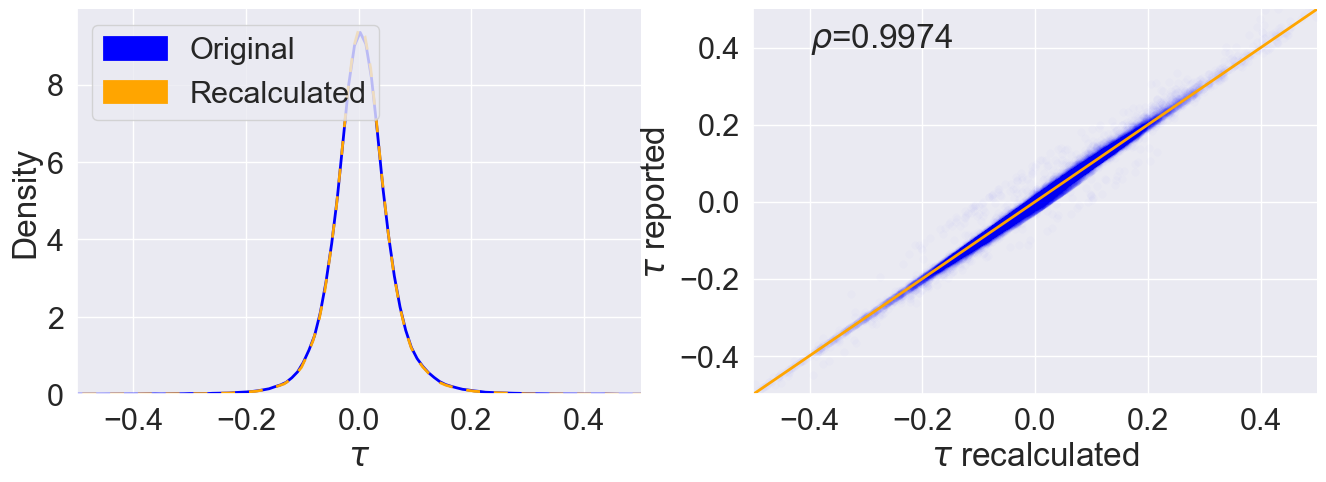

In [6]:
df = df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])

threshold = 0.1     # threshold for the discrepancy between reported results and calulcated results; if discrepancy greater than this, we exclude these gene triplets

df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i

# filter out results that aren't reproducible according to the original equation
print("fraction of tau values that remain after filtering out deviants")
print(len(df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold])/len(df))

df = df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold]

sns.set(font_scale = 2)
fig, axs = plt.subplots(ncols=2, figsize=(16,5))

pl = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue", linewidth=2)
pl = sns.kdeplot(df['tau_kuzmin_orig'], ax=axs[0], color="orange", linestyle=(0,(5,5)), linewidth=2)
pl.set(xlabel=r'$\tau$')
axs[0].set_xlim(-0.5,0.5)
# create legend
orange_patch = FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.3", ec="orange", fc="orange", lw=2)
blue_patch = FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.3", ec="blue", fc="blue", lw=2)
axs[0].legend([blue_patch, orange_patch], ['Original', 'Recalculated'], loc='upper left')


pl = sns.scatterplot(x=df['tau_kuzmin_orig'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            alpha=0.01,
            linewidth=0,
            color="blue",
            ax=axs[1])
axs[1].plot([-1, 1], [-1, 1], linewidth=2, color="orange")
pl.set(xlabel=r'$\tau$' + ' recalculated', ylabel=r'$\tau$' + ' reported')
axs[1].set_xlim(-0.5,0.5)
axs[1].set_ylim(-0.5,0.5)


df[['tau_kuzmin_orig', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")
pcorr = str(round(float(df[['tau_kuzmin_orig', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson").tau_kuzmin_orig[1]),4))
axs[1].text(x=-0.4, y=0.4, s=r"$\rho$="+pcorr)

sns.despine()

By substituting in the values for the various interaction measures, the formula for $\tau_{ijk}$ can be re-written as:

$\tau_{ijk} = f_{ijk} + 2f_{i}f_{j}f_{k} - f_{i}f_{jk} - f_{j}f_{ik} - f_{k}f_{ij}$

However, recalculating $\tau_{ijk}$ in this way produces values that are ***not*** consistent with reported values because the following equalities should be true but, with these data, they are not:

$f_{jk} \ne (f_jf_k + e_{jk})$ and  $f_{ik} \ne (f_if_k + e_{ik})$

If instead of using the double mutant fitnesses on the left-hand side of these equalities we instead use the formula on the right-hand side, we observe values for $\tau_{ijk}$ similar to those reported. These newly recalculated double mutant fitnesses are suffixed with 2: `f_ik_2` and `f_jk_2`.

In [7]:
df.loc[:, 'tau_chimeric'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij

df.loc[:,'e_ik_mult'] = df.f_ik/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult'] = df.f_jk/(df.f_j*df.f_k)
#df.loc[:,'tau_multiplicative'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult*df.e_jk_mult) 
df.loc[:,'tau_multiplicative'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik*df.f_jk) 

df.loc[:, 'f_ik_2'] = df.f_i*df.f_k + df.e_ik_kuz
df.loc[:, 'f_jk_2'] = df.f_j*df.f_k + df.e_jk_kuz

df.loc[df['f_ik_2'] < 0, ['f_ik_2']] = np.nan
df.loc[df['f_jk_2'] < 0, ['f_jk_2']] = np.nan

df.loc[:,'e_ik_mult2'] = df.f_ik_2/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult2'] = df.f_jk_2/(df.f_j*df.f_k)
df.loc[:,'e_ij_mult'] = df.f_ij/(df.f_i*df.f_j)

df.loc[:, 'tau_chimeric2'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk_2 - df.f_j*df.f_ik_2 - df.f_k*df.f_ij

# calculate multiplicative results using the custom dbl mutant fitnesses that gave results consistent with those reported (above)
# compare these with tau_chimeric2
df.loc[:,'tau_multiplicative2'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik_2*df.f_jk_2) 

To visualize the discrepancies between reported and recalculated values of $\tau_{ijk}$, we plot recalculated $\tau_{ijk}$ values using the double mutant fitnesses, $f_{ik}$ and $f_{jk}$ (left) or instead substituting in the values $f_if_k + e_{ik}$ and $f_jf_k + e_{jk}$, respectively

/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_27573/3201708785.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pcorr = str(round(float(df[[tau, 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")[t

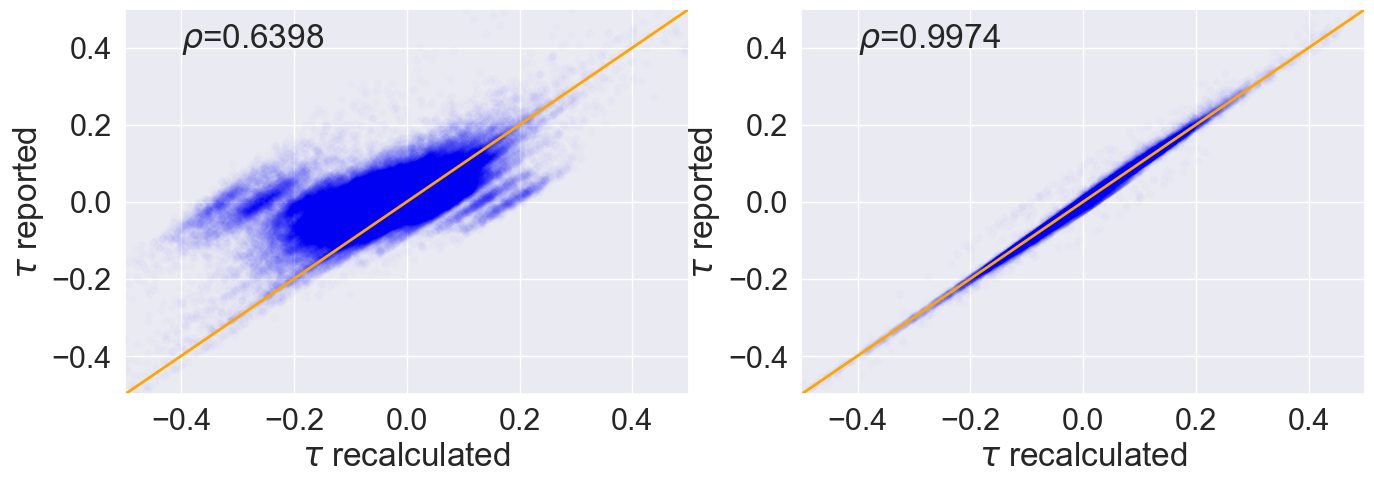

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))

def mk_scatter(df,tau,i):
    pl = sns.scatterplot(x=df[tau],
                y=df['adjusted_interaction_score_epsilon_or_tau'],
                alpha=0.01,
                linewidth=0,
                color="blue", 
                ax=axs[i])
    axs[i].plot([-1, 1], [-1, 1], linewidth=2, color="orange")
    axs[i].set(xlabel=r'$\tau$' + ' recalculated', ylabel=r'$\tau$' + ' reported')
    axs[i].set_xlim(-0.5,0.5)
    axs[i].set_ylim(-0.5,0.5)

    pcorr = str(round(float(df[[tau, 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")[tau][1]),4))
    axs[i].text(x=-0.4, y=0.4, s=r"$\rho$="+pcorr)

mk_scatter(df, "tau_chimeric", 0)
mk_scatter(df, "tau_chimeric2", 1)

Based on these results, we set a variable `use_reported_double_mutant_fitnesses` to `False` in order to avoid using double mutant fitnesses that give discordant results. You may set this to `True` to explore the effects of calculating $\tau_{ijk}$ with double mutant fitnesses.

We also specify what values to compare to the multiplicative metric, either the values reported in the tables provided by Kuzmin or recalculated version based on the chimeric formula.

In [9]:
# This logical switch is used to change all downstream analyses

use_reported_double_mutant_fitnesses = False
compare_to_reported_values = True # if False, compare instead to values recalculated with chimeric formula

if use_reported_double_mutant_fitnesses:
    multiplicative = "tau_multiplicative"
    chimeric = "tau_chimeric"
else:
    multiplicative = "tau_multiplicative2"
    chimeric = "tau_chimeric2"

if compare_to_reported_values:
    compare = "adjusted_interaction_score_epsilon_or_tau"
else:
    compare = chimeric

### Comparing the multiplicative and chimeric measures

We will first compare the overall distributions of the trigenic interaction scores callculated using the chimeric and multiplicative formulas, and then we will see how outliers differ between the two measures.

To see how outliers differ across the chimeric and multiplicative measures, we can calculate a significance threshold for the multiplicative scale by finding the quantile that corresponds +/- 0.08, the trigenic score threshold Kuzmin et al use to find positive/negative outliers using the chimeric formula.

We will store these thresholds in dictionaries.

In [10]:
tau_reported_sig_quant, tau_mult_sig_val, tau_chim_sig_val = {},{},{}

# get quantiles
tau_reported_sig_quant['neg'] = np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) < -0.08)
tau_reported_sig_quant['pos'] = 1 - np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) > 0.08)

# calculate significance thresholds on new scales using quantile
tau_mult_sig_val['neg'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['neg'])
tau_mult_sig_val['pos'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['pos'])

tau_chim_sig_val['neg'] = np.nanquantile(df[chimeric], tau_reported_sig_quant['neg'])
tau_chim_sig_val['pos'] = np.nanquantile(df[chimeric], tau_reported_sig_quant['pos'])

print("quantiles of the significant values they used",  tau_reported_sig_quant['neg'], tau_reported_sig_quant['pos'] )
print("confirming (should be -0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['neg']))
print("confirming (should be 0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['pos']))
print()
print( "corresponding cutoffs for multiplicative model: ", tau_mult_sig_val['neg'], tau_mult_sig_val['pos'])
print( "corresponding cutoffs for chimeric model: ", tau_chim_sig_val['neg'], tau_chim_sig_val['pos'])


quantiles of the significant values they used 0.0505675568891689 0.9305530342669813
confirming (should be -0.08): -0.07998675851335334
confirming (should be 0.08): 0.07998704170448598

corresponding cutoffs for multiplicative model:  0.9051323011432824 1.1071547776828772
corresponding cutoffs for chimeric model:  -0.07906997897906276 0.07887639643511796


#### Compare the overall distributions for each measure
To more easily compare the two distributions, we center the chimeric metric around 1 instead of 0, as the multiplicative metric is centered around 1, the value corresponding to no interaction.

/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd

                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.983062   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.983062  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.915095   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.915095  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplica

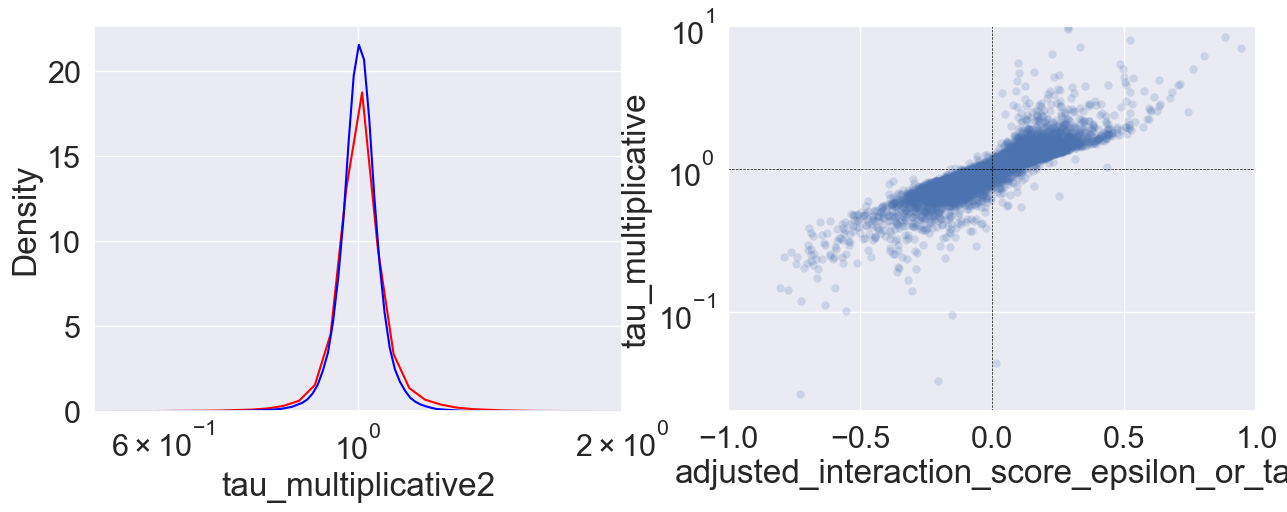

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =10
pl = sns.kdeplot(df[multiplicative], ax = axs[0], color="red", log_scale=True)
#p = sns.kdeplot(df[multiplicative], ax = axs[0], color="red")
# add one so distributions are more comparable
pl = sns.kdeplot(df[compare]+1, ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

pl = sns.scatterplot(x=df[compare],
            y=df[multiplicative],
            alpha=0.2,
            linewidth=0,
            ax=axs[1])
pl.set(xlabel=compare, ylabel='tau_multiplicative')
axs[1].set_xlim(-1,1)
axs[1].set_yscale('log')
axs[1].set_ylim(0.02,10)
axs[1].axhline(1, color="black", linestyle="--", linewidth=0.5)
axs[1].axvline(0, color="black", linestyle="--", linewidth=0.5)
#axs[1].axhline(tau_mult_sig_val['neg'], color="red", linestyle="--", linewidth=0.5)
#axs[1].axhline(tau_mult_sig_val['pos'], color="red", linestyle="--", linewidth=0.5)
#axs[1].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
#axs[1].axvline(0.08, color="red", linestyle="--", linewidth=0.5)

print(df[[multiplicative, compare]].corr(method="spearman"))
print(df[[multiplicative, compare]].corr(method="kendall"))
print(df[[multiplicative, compare]].corr(method="pearson"))


#### Compare outliers for each measure

Analyze the fraction of positive and negative outliers. Here an outlier is defined not only by it's value being beyond a threshold, but also it's p-value being below p=0.05 (defined in a cell towards the top of this notebook). These p-values are taken directly from the supplementary tables of the Kuzmin papers.

In [12]:
def create_compare_pos_neg_dict(df, pval, multiplicative, compare, tau_mult_sig_val):
    compare_pos_neg = {}
    compare_pos_neg['mult_total'] = len(df[(df.pval < pval) & (df[multiplicative] < tau_mult_sig_val['neg'])]) + len(df[(df.pval < pval) & (df[multiplicative] > tau_mult_sig_val['pos'])])
    compare_pos_neg['mult_neg'] = len(df[(df.pval < pval) & (df[multiplicative] < tau_mult_sig_val['neg'])])/compare_pos_neg['mult_total']
    compare_pos_neg['mult_pos'] = len(df[(df.pval < pval) & (df[multiplicative] > tau_mult_sig_val['pos'])])/compare_pos_neg['mult_total']

    compare_pos_neg['chimeric_total'] = len(df[(df.pval < pval) & (df[compare] < -0.08)]) + len(df[(df.pval < pval) & (df[compare] > 0.08)])
    compare_pos_neg['chimeric_neg'] = len(df[(df.pval < pval) & (df[compare] < -0.08)])/compare_pos_neg['chimeric_total']
    compare_pos_neg['chimeric_pos'] = len(df[(df.pval < pval) & (df[compare] > 0.08)])/compare_pos_neg['chimeric_total']

    return compare_pos_neg


compare_pos_neg = create_compare_pos_neg_dict(df, p, multiplicative, compare, tau_mult_sig_val)

compare_pos_neg
# NOTE: differences between models disappear when not filtering based on pvalue

{'mult_total': 3459,
 'mult_neg': 0.5790690951141949,
 'mult_pos': 0.42093090488580515,
 'chimeric_total': 2946,
 'chimeric_neg': 0.5492192803801765,
 'chimeric_pos': 0.45078071961982347}

Classify gene triplet outliers into 3 important categories:

1. outlier uniquely detected using the multiplicative formula (stored in `only_mult`)
2. outlier uniquely detected using the chimeric formula (stored in `only_chimeric`)
3. outlier detected using either formula, multiplicative or chimeric (stored in `overlap`)

However, while were at it, we also store **all** outliers according to the chimeric and multiplicative formula in `all_chimeric` and `all_mult`, respectively.

The function `enrich.outlier_enrichment` is very flexible and used extensively in this codebase.

`enrich.outlier_enrichment` has as input a DataFrame (1st argument), which it divides into these outlier categories above using basic Pandas subsetting techniques, storing each as a smaller, subsetted DataFrame that it passes to another function (3rd argument) that performs a simple calculation on this subsetted DataFrame. For instance, below we give these subsetted DataFrames to `count_frac` function, which simply returns the length (an int) of the dataframe. However, we can also have this function (3rd argument) perform other operations on these subsetted DataFrames, such as computing the total number of outliers for that category AND the number of these outliers that contain physical protein-protein interactions.


In [13]:
def count_frac(df : pd.DataFrame) -> int:
    return len(df)
    
results = defaultdict(list)

overlap, only_chimeric, only_mult, all_chimeric, all_mult = enrich.outlier_enrichment( df[df.pval < p], "negative", count_frac, multiplicative, tau_mult_sig_val)
denom = overlap + only_chimeric + only_mult

results['type'].extend(['only multiplicative', 'overlap', 'only chimeric'])
results['number'].extend([only_mult, overlap, only_chimeric])
results['fraction'].extend([only_mult/denom, overlap/denom, only_chimeric/denom])

pd.DataFrame.from_dict(results)

,type,number,fraction
0,only multiplicative,476,0.227316
1,overlap,1527,0.729226
2,only chimeric,91,0.043457


Make a Venn diagram

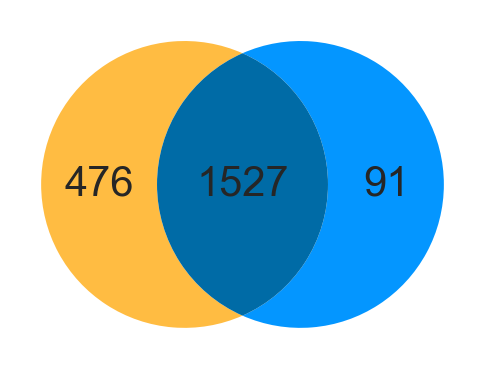

In [14]:
overlap_color = "#006BA6"
only_mult_color = "#FFBC42"
only_chimeric_color = "#0496FF"

only_mult_venn, only_chimeric_venn, overlap_venn = None, None, None
# copy values since similar names get used elsewhere in notebook
if not only_mult_venn and not only_chimeric_venn and not overlap_venn:
    only_mult_venn = only_mult
    only_chimeric_venn = only_chimeric
    overlap_venn = overlap

plt.figure(figsize=(6,6))
v = venn2_unweighted(subsets = (only_mult, only_chimeric, overlap), set_labels = ('', '', ''), set_colors=(only_mult_color, 
                                                                                            only_chimeric_color,
                                                                                            overlap_color), alpha = 1)
v.get_patch_by_id('11').set_color(overlap_color)
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('11').set_alpha(1)

for text in v.set_labels:
    text.set_fontsize(14)
for text in v.subset_labels:
    text.set_fontsize(30)

print(v)
plt.show()

## Assess biology of results
Below, we will see how often these outliers, which are candidates for having trigenic interactions, overlap with other features known about the gene triplet such as:
1. physical protein-protein interactions
2. correlation in expression values
3. shared GO annotations

In [15]:
# Here we load in pairwise physical interactions from a database.

# BIOGRID contains physical interactions measured from a variety of assays including co-localization
# see here for explanation of experimental evidence codes: https://wiki.thebiogrid.org/doku.php/experimental_systems
db_interactions = db.get_physical_interactions_BIOGRID()
# specify which experimental systems will be used for determining physical interactions
experimental_systems = ['Affinity Capture-MS', 'Affinity Capture-Western', 'Two-hybrid', 'Reconstituted Complex', 'PCA', 'Co-purification', 'Co-crystal Structure']
print(db_interactions.experimental_system.value_counts())

db_interactions = db_interactions[db_interactions.experimental_system.isin(experimental_systems)]

/Users/bjarnold/Princeton_EEB/epistasis/chimeric-epistasis/yeast_screens/databases.py:35: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  db_interactions = pd.read_csv(f"{db_dir}/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-4.4.211.tab3.txt", sep="\t")


experimental_system
Negative Genetic                 419139
Affinity Capture-MS               95645
Positive Genetic                  83564
Synthetic Growth Defect           28938
Affinity Capture-RNA              27787
Affinity Capture-Western          21182
Two-hybrid                        19089
Synthetic Lethality               17342
Reconstituted Complex             10560
Synthetic Rescue                   9534
Phenotypic Enhancement             9265
Phenotypic Suppression             8930
Biochemical Activity               7400
PCA                                7311
Dosage Rescue                      6919
Co-purification                    5314
Dosage Lethality                   2277
Dosage Growth Defect               2244
Co-crystal Structure               1246
Co-fractionation                   1245
Proximity Label-MS                  939
Protein-peptide                     933
Co-localization                     898
Protein-RNA                         674
Synthetic Haploinsuf

First, we count the number of physical interactions between each gene in the triplet.

Second, check whether genes in the triplet have shared physical interactions, i.e. whether all three genes interact with a fourth gene that is not in the gene triplet set.

In [16]:
# compute physical interactions within gene triplet
physical_pairwise_interactions_set = db.find_unique_interactions(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
num_physical_interactions, oneplus_physical_interactions, twoplus_physical_interactions, three_physical_interactions = db.count_interactions_in_set(df, physical_pairwise_interactions_set)
df['num_physical_interactions'] = df['alleles'].map(num_physical_interactions)
df['three_physical_interactions'] = df['alleles'].map(three_physical_interactions)

# compute shared physical interactions
physical_pairwise_interactions_dict = db.collect_interactions_in_dict(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
three_shared_physical_interactions = db.count_shared_interactions_in_dict(df, physical_pairwise_interactions_dict, 1)
df['three_shared_physical_interactions'] = df['alleles'].map(three_shared_physical_interactions)


Test whether gene triplets that are outliers according to the multiplicative formula, but not the chimeric formula, are significantly enriched for shared physical interactions.

Here `enrich.outlier_enrichment` return dicts for each category of outlier. E.g. in the cell below, `overlap` is a dict with 3 keys: 
- `tot`: the total number of outliers in this category
- `int`: the number of these outliers in this category that have a shared physical protein-protein interaction
- `frac`: `int` / `tot`


In [17]:
overlap, only_chimeric, only_mult, all_chimeric, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)
# since only_mult has more observations than only_chimeric, treat only_mult as the "population" and only_chimeric as the "sample" for the hypergeometric test to see if the fraction of shared physical interactions is significantly different
# and use the hypergeom cdf to do a lower-tailed test
test = hypergeom.cdf(*enrich.get_hypergeom_params(only_chimeric, only_mult))

print(f'P-value {test}')
print(f'fraction of chimeric formula outliers with 3 shared PPIs:', only_chimeric['frac'])
print(f'fraction of multiplicative formula outliers with 3 shared PPIs:', only_mult['frac'])

P-value 0.001847093584519029
fraction of chimeric formula outliers with 3 shared PPIs: 0.12087912087912088
fraction of multiplicative formula outliers with 3 shared PPIs: 0.23739495798319327


We can also characterize gene triplets in terms of patterns of co-expression and divergent expression.

In [18]:
# arg that goes into get_coexpression_gene_pairs is the z-score associated with how significant the correlation b/t expression is
coexpression_gene_pairs_set, divexpression_gene_pairs_set = db.get_expression_gene_pairs(3)

num_coex_interactions, oneplus_coex_interactions, twoplus_coex_interactions, three_coex_interactions = db.count_interactions_in_set(df, coexpression_gene_pairs_set)
num_divex_interactions, oneplus_divex_interactions, twoplus_divex_interactions, three_divex_interactions = db.count_interactions_in_set(df, divexpression_gene_pairs_set)

df['num_coex_interactions'] = df['alleles'].map(num_coex_interactions)
df['oneplus_coex_interactions'] = df['alleles'].map(oneplus_coex_interactions)
df['twoplus_coex_interactions'] = df['alleles'].map(twoplus_coex_interactions)
df['three_coex_interactions'] = df['alleles'].map(three_coex_interactions)

df['num_divex_interactions'] = df['alleles'].map(num_divex_interactions)
df['oneplus_divex_interactions'] = df['alleles'].map(oneplus_divex_interactions)
df['twoplus_divex_interactions'] = df['alleles'].map(twoplus_divex_interactions)
df['three_divex_interactions'] = df['alleles'].map(three_divex_interactions)

print(df['num_coex_interactions'].value_counts())


num_coex_interactions
0    134619
1     51800
2       662
3       213
Name: count, dtype: int64


Lastly, we can see which gene triplets contain genes that are all members of at least one GO category

In [19]:
threeway_shared_go = db.count_shared_go(df)
df['threeway_shared_go'] = df['alleles'].map(threeway_shared_go)
print(np.sum(df.threeway_shared_go)/len(df))


0.10800666332076841


See to what degree each category of outlier is significantly enriched for gene triplets that contain genes that share a GO pathway.

In [20]:
print(enrich.perform_hypergeom_test(df[df.pval < p], "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val))

            type          pval
0        overlap  1.114507e-05
1  only_reported  4.206507e-01
2      only_mult  2.094051e-05
3   all_reported  1.601011e-05
4       all_mult  5.064555e-10


For each category of outlier, assess significance of enrichment for 3 biological signals: coexpression, shared GO categories, and shared PPI.

The results of the following analyses are what are used to claim significance in Figure 4B of the manuscript.

In [21]:
print("COEXPRESSION ENRICHMENT P-VALUES")
print(enrich.perform_hypergeom_test(df[df.pval < p], "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val))

print("GO ENRICHMENT P-VALUES") 
print(enrich.perform_hypergeom_test(df[df.pval < p], "negative", enrich.fraction_threeway_shared_go, multiplicative, tau_mult_sig_val))

print("SHARED PPI ENRICHMENT P-VALUES")
print(enrich.perform_hypergeom_test(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val))

COEXPRESSION ENRICHMENT P-VALUES
            type      pval
0        overlap  0.016389
1  only_reported  0.274767
2      only_mult  0.017843
3   all_reported  0.018366
4       all_mult  0.001305
GO ENRICHMENT P-VALUES
            type          pval
0        overlap  1.114507e-05
1  only_reported  4.206507e-01
2      only_mult  2.094051e-05
3   all_reported  1.601011e-05
4       all_mult  5.064555e-10
SHARED PPI ENRICHMENT P-VALUES
            type          pval
0        overlap  1.096267e-03
1  only_reported  8.933415e-01
2      only_mult  1.418961e-04
3   all_reported  4.046685e-03
4       all_mult  9.495384e-07


Previously, we performed hypergeometric tests to see if each category of outlier was individually enriched for a particular biological signal. However, we can also directly compare classes of outliers against each other to assess whether one is **more** significantly enriched than the other. For instance, we can test whether the set of all multiplicative outliers is more or less significantly enriched for shared protein-protein interactions compared to the set of all chimeric outliers.

In [22]:
# # Directly compare multiplicative and chimeric using hypergeometric test

# def get_sample_population(all_chimeric, all_mult):
#     """
#     this small function is used to determine which class of outliers is larger, all_chimeric or all_mult
#     whichever one is larger is treated as the "population" and the other as the "sample" for the hypergeometric test
#     this also dictates whether we want to perform a lower-tailed or upper-tailed test
#     """
#     if all_mult['tot'] >= all_chimeric['tot']:
#         # perform lower tail test to see if all_chimeric significantly less enriched
#         return all_chimeric, all_mult, "lower" 
#     else:
#         # perform upper tail test to see if all_mult more enriched
#         return all_mult, all_chimeric, "upper"

# print("DIRECTLY COMPARE MULT AND CHIMERIC")
# print("GO ENRICHMENT")
# overlap, only_chimeric, only_mult, all_chimeric, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_threeway_shared_go, multiplicative, tau_mult_sig_val)
# # since all_mult has more observations than all_chimeric, treat all_mult as the "population" and all_chimeric as the "sample" for the hypergeometric test
# # and use the hypergeom cdf to do a lower-tailed test
# sample, population, test_tail = get_sample_population(all_chimeric, all_mult)
# print(all_chimeric)
# print(all_mult)
# if test_tail == "lower":
#     test = hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
# elif test_tail == "upper":
#     test = 1-hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
# print(test)

# print("shared PPI")
# overlap, only_chimeric, only_mult, all_chimeric, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)
# # since all_mult has more observations than all_chimeric, treat all_mult as the "population" and all_chimeric as the "sample" for the hypergeometric test
# # and use the hypergeom cdf to do a lower-tailed test
# sample, population, test_tail = get_sample_population(all_chimeric, all_mult)
# print(all_chimeric)
# print(all_mult)
# if test_tail == "lower":
#     test = hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
# elif test_tail == "upper":
#     test = 1-hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
# print(test)

# print("COEXPRESSION")
# overlap, only_chimeric, only_mult, all_chimeric, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val)
# # since all_mult has more observations than all_chimeric, treat all_mult as the "population" and all_chimeric as the "sample" for the hypergeometric test
# # and use the hypergeom cdf to do a lower-tailed test
# sample, population, test_tail = get_sample_population(all_chimeric, all_mult)
# print(all_chimeric)
# print(all_mult)
# if test_tail == "lower":
#     test = hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
# elif test_tail == "upper":
#     test = 1-hypergeom.cdf(*enrich.get_hypergeom_params(sample, population))
# print(test)

Gather the results of these enrichment tests into a single data structure to use for plotting Figure 4b.

In [23]:
data1 = []
data2 = []
funcs = [enrich.fraction_coex_twoplus, enrich.fraction_three_shared, enrich.fraction_threeway_shared_go]
for func in funcs:
    genome_wide = func(df)
    overlap, only_chimeric, only_mult, all_chimeric, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)
    #d1 = [overlap['frac']/genome_wide['frac'], only_chimeric['frac']/genome_wide['frac'], only_mult['frac']/genome_wide['frac']]
    d1 = [only_mult['frac']/genome_wide['frac'], overlap['frac']/genome_wide['frac'], only_chimeric['frac']/genome_wide['frac']]
    d2 = [all_chimeric['frac']/genome_wide['frac'], all_mult['frac']/genome_wide['frac']]
    data1.append(d1)
    data2.append(d2)

data1 = np.transpose(data1)
data2 = np.transpose(data2)

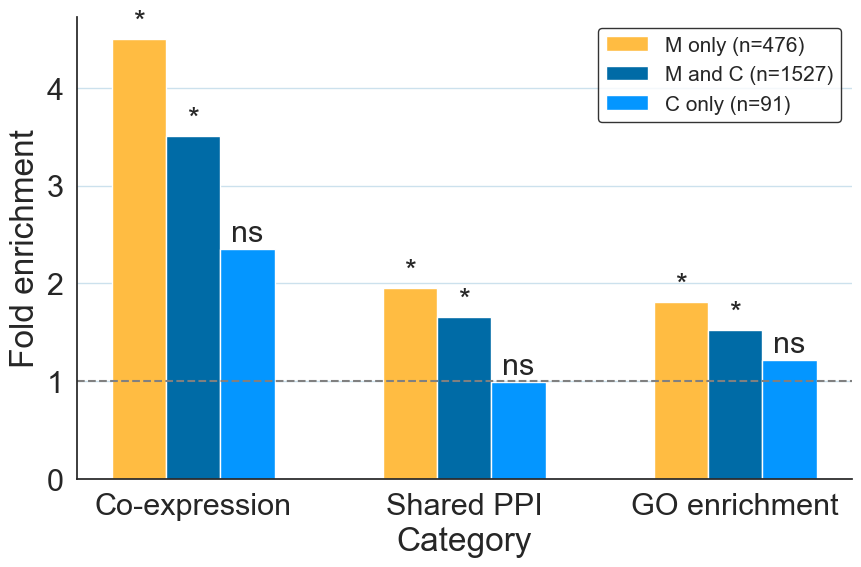

In [24]:
sns.set_style("white")
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(figsize=(10,6))

# data: 
# rows are data category (only mult, overlap, only reported),
# cols are analysis (coex, PPI, GO)
x = np.arange(len(data1[0]))
width = 0.2
plt.bar(x-width, data1[0], width, color=only_mult_color) # plots first analysis across all data categories (coex, PPI, GO)
plt.bar(x, data1[1], width, color=overlap_color)
plt.bar(x+width, data1[2], width, color=only_chimeric_color)

plt.xticks(x, ['Co-expression', 'Shared PPI', 'GO enrichment'])
plt.xlabel("Category")
plt.ylabel("Fold enrichment")
plt.legend([f"M only (n={results['number'][0]})", 
            f"M and C (n={results['number'][1]})", 
            f"C only (n={results['number'][2]})"], loc='upper right', prop={'size':15}, edgecolor="black")
plt.axhline(1, linestyle="--", color="gray")
plt.grid(visible=True, axis='y', alpha=0.2, color=overlap_color)

sns.despine()

# add annotations for statistical significance
analyses = ["coex", "ppi", "go"]
for column in range(len(data1[0])):
    analysis = analyses[column]
    if dataset == "Kuzmin2020":
        # for 2020 data:
        # overlap and only_mult significant for all analyses, only_chimeric not significant for all analyses
        # this is the cae when pval threshold is 0.05 or 1
        plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom')
        plt.text(column, data1[1][column]+0.02, "*", ha='center', va='bottom')
        plt.text(column+width, data1[2][column]+0.02, "ns", ha='center', va='bottom')
    elif dataset == "Kuzmin2018":
        # for 2018 data:
        # overlap significant for all, only_mult significant only for GO and PPI, only_chimeric only significant for GO
        if analysis == "coex":
            plt.text(column-width, data1[0][column]+0.02, "ns", ha='center', va='bottom') # only_mult
            plt.text(column, data1[1][column]+0.02, "*", ha='center', va='bottom') # overlap
            plt.text(column+width, data1[2][column]+0.02, "ns", ha='center', va='bottom') # only_chimeric              
        if analysis == "ppi":
            plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom') # only_mult
            plt.text(column, data1[1][column]+0.02, "*", ha='center', va='bottom') # overlap
            plt.text(column+width, data1[2][column]+0.02, "ns", ha='center', va='bottom') # only_chimeric            
        if analysis == "go":
            plt.text(column-width, data1[0][column]+0.02, "*", ha='center', va='bottom') # only_mult  
            plt.text(column, data1[1][column]+0.02, "*", ha='center', va='bottom') # overlap
            if p==1:
                plt.text(column+width, data1[2][column]+0.02, "ns", ha='center', va='bottom') # only_chimeric
            else:
                plt.text(column+width, data1[2][column]+0.02, "ns", ha='center', va='bottom') # only_chimeric
                  
plt.show()
# plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/panels_tmp/barpot_by_category.pdf')


Make a 2D scatterplot showing the values of the chimeric metric and multiplicative metric for each gene triplet for Figure 4A.

/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_27573/1407312170.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlap['type'] = "M and C"
/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_27573/1407312170.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_mult['type'] = "M only"
/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_27573/1407312170.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

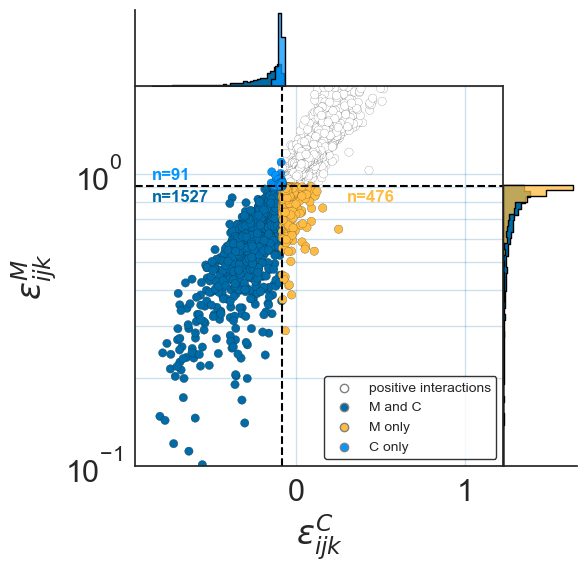

In [25]:
sns.set_style("white")
plt.rcParams.update({'font.size': 22})
alph = 1
lw = 0.1
bin_wid = 0.02

overlap = df[(df.pval <= p) & (df.adjusted_interaction_score_epsilon_or_tau <= -0.08) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
only_mult = df[(df.pval <= p) & (df.adjusted_interaction_score_epsilon_or_tau > -0.08) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
only_chimeric = df[(df.pval <= p) & (df.adjusted_interaction_score_epsilon_or_tau <= -0.08) & (df[multiplicative] > tau_mult_sig_val['neg'])]
all = df[(df.pval <= p)]

overlap['type'] = "M and C"
only_mult['type'] = "M only"
only_chimeric['type'] = "C only"
all['type'] = 'positive interactions'

test = pd.concat([all, overlap, only_mult, only_chimeric])
sns.set_palette(['white', overlap_color, only_mult_color, only_chimeric_color])

g = sns.JointGrid(x='adjusted_interaction_score_epsilon_or_tau', y=multiplicative, data=test, hue='type', space=0)
g.ax_joint.grid(visible=True, axis='both', alpha=0.2, which='both', color=overlap_color )

sns.scatterplot(data=test,
                x='adjusted_interaction_score_epsilon_or_tau',
                y=multiplicative,
                hue='type',
                alpha=alph,
                linewidth=lw,
                edgecolor="black",
                ax=g.ax_joint)

if dataset == "Kuzmin2018":
    g.ax_joint.set_ylim(0.1,2)
    g.ax_joint.set_xlim(-0.9,0.15)
else:
    g.ax_joint.set_ylim(0.1,2)

g.ax_joint.set_yscale('log')
g.ax_joint.axvline(-0.08, linestyle="--", color="black")
g.ax_joint.axhline(tau_mult_sig_val['neg'], linestyle="--", color="black")

g.ax_joint.set_xlabel(r'$\epsilon_{ijk}^C$')
g.ax_joint.set_ylabel(r'$\epsilon_{ijk}^M$')

sns.histplot(overlap, x='adjusted_interaction_score_epsilon_or_tau', color=overlap_color, stat='probability', binwidth=bin_wid, element='step', edgecolor="black", alpha=1, ax=g.ax_marg_x)
sns.histplot(only_chimeric, x='adjusted_interaction_score_epsilon_or_tau', color=only_chimeric_color, stat='probability', binwidth=bin_wid, element='step', edgecolor="black",ax=g.ax_marg_x)

sns.histplot(overlap, y=multiplicative, color=overlap_color, stat='probability', binwidth=bin_wid, element='step', edgecolor="black", alpha=1, ax=g.ax_marg_y)
sns.histplot(only_mult, y=multiplicative, color=only_mult_color, stat='probability', binwidth=bin_wid, element='step', edgecolor="black", ax=g.ax_marg_y)

legend_properties = {'size':10}
handles, labels = g.ax_joint.get_legend_handles_labels()
[ha.set_edgecolor("gray") for ha in handles]
legendMain=g.ax_joint.legend(prop=legend_properties,loc='lower right', edgecolor='black')

#g.ax_joint.text(xy=(1.0, 13.0), "An annotation", horizontalalignment='left', size='medium', color='black', weight='semibold')
# reported only
g.ax_joint.text(-0.85, 0.95, f"n={results['number'][2]}", horizontalalignment='left', size=12, color=only_chimeric_color, weight='semibold')
# overlap
g.ax_joint.text(-0.85, 0.80,  f"n={results['number'][1]}", horizontalalignment='left', size=12, color=overlap_color, weight='semibold')
# mult only
if dataset == "Kuzmin2018":
    g.ax_joint.text(-0.06, 0.11,  f"n={results['number'][0]}", horizontalalignment='left', size=12, color=only_mult_color, weight='semibold')
else:  
    g.ax_joint.text(0.3, 0.8,  f"n={results['number'][0]}", horizontalalignment='left', size=12, color=only_mult_color, weight='semibold')

sns.despine()

# plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/panels_tmp/jointgrid.pdf')

Classify each gene triplet according to their chimeric and multiplicative metric values, that is whether they're positive, negative, or 'neutral'/'ambiguous' and do not exceed the threshold for being classified as positive or negative. These results comprise Table 2 in the manuscript.

In [26]:
# create 3X3 table of counts for each of the 9 possible combinations of multiplicative and chimeric: positive, neutral, negative
table = defaultdict(float)

chimeric_upper = 0.08
chimeric_lower = -0.08

def compute_three_by_three_table_entries(df, multiplicative, chimeric_upper, chimeric_lower, mult_upper, mult_lower):
    return len(df[(df.adjusted_interaction_score_epsilon_or_tau > chimeric_lower) & (df.adjusted_interaction_score_epsilon_or_tau < chimeric_upper) & 
       (df[multiplicative] > mult_lower) & (df[multiplicative] < mult_upper)])
    
d = df[df.pval < p]
# upper bound is lower threshold, lower bound is low enough to capture entire tail
table['both_neg'] = compute_three_by_three_table_entries(d, multiplicative, -0.08, -300, tau_mult_sig_val['neg'], -1)
table['both_pos'] = compute_three_by_three_table_entries(d, multiplicative, 300, 0.08, 1000, tau_mult_sig_val['pos'])
table['both_neut'] = compute_three_by_three_table_entries(d, multiplicative, 0.08, -0.08, tau_mult_sig_val['pos'], tau_mult_sig_val['neg'])

table['chim_neut_mult_pos'] = compute_three_by_three_table_entries(d, multiplicative, 0.08, -0.08, 1000, tau_mult_sig_val['pos'])
table['chim_neg_mult_pos'] = compute_three_by_three_table_entries(d, multiplicative, -0.08, -300, 1000, tau_mult_sig_val['pos'])

table['chim_pos_mult_neut']= compute_three_by_three_table_entries(d, multiplicative, 300, 0.08, tau_mult_sig_val['pos'], tau_mult_sig_val['neg'])
table['chim_neg_mult_neut']= compute_three_by_three_table_entries(d, multiplicative, -0.08, -300, tau_mult_sig_val['pos'], tau_mult_sig_val['neg'])

table['chim_pos_mult_neg'] = compute_three_by_three_table_entries(d, multiplicative, 300, 0.08, tau_mult_sig_val['neg'], -1)
table['chim_neut_mult_neg'] = compute_three_by_three_table_entries(d, multiplicative, 0.08, -0.08, tau_mult_sig_val['neg'], -1)
table

print(len(d))
print(np.sum([table[k] for k in table.keys()]))

7964
7957


In [27]:
for k in table.keys():
    print(k, table[k])

total = np.sum([table[k] for k in table.keys()])
numerator = np.sum([table[k] for k in table.keys() if k not in ['both_neg', 'both_pos', 'both_neut']])
print(numerator/total)

both_neg 1527
both_pos 1197
both_neut 4291
chim_neut_mult_pos 259
chim_neg_mult_pos 0
chim_pos_mult_neut 116
chim_neg_mult_neut 91
chim_pos_mult_neg 10
chim_neut_mult_neg 466
0.11838632650496418


For a given gene triplet, plot the observed fitnesses of each single mutant, each double mutant, and the triple mutant. Also plot the predicted fitness if there were no three-way interaction. This is Figure S6 in the manuscript, which is a more visual way of showing the presence of trigenic interactions.

           f_i      f_j   f_k     f_ij    f_ik_2    f_jk_2  \
227988  0.6833  0.96076  0.34  0.61648  0.001218  0.499927   

        double_triple_mutant_fitness  
227988                        0.1267  


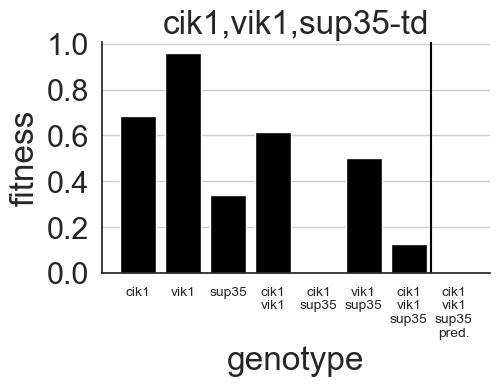

In [28]:
#a = "lsb1,pin3,cog3-1"
#a = "heh2,src1,sec66"
#a = "are1,are2,sed5-1"
#a = "fat3,ina1,neo1-2"
#a = "nup53,asm4,nup145-R4"
#a = "heh2,src1,pom152"
#a = "nup53,asm4,nup133"
a = "cik1,vik1,sup35-td"

fitnesses = d[['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik_2', 'f_jk_2', 'double_triple_mutant_fitness']][d.alleles == a]
print(fitnesses)
mult_epi = d[['e_ij_mult', 'e_ik_mult2', 'e_jk_mult2', 'tau_multiplicative2']][d.alleles == a]
ijk_predicted = fitnesses.f_i*fitnesses.f_j*fitnesses.f_k*mult_epi.e_ij_mult*mult_epi.e_ik_mult2*mult_epi.e_jk_mult2
fitnesses['ijk_predicted'] = ijk_predicted
# set size of figure
fig, ax = plt.subplots(figsize=(5,3))

# create barplot of fitnesses
colors = ['black']*3 + ['red']*3 + ['blue']*2 + ['green']
ax.bar(fitnesses.columns, fitnesses.values[0], color="black")
# create custom x-axis labels
plt.xticks(fitnesses.columns, rotation=0, labels = ['cik1', 'vik1', 'sup35', 'cik1\nvik1', 'cik1\nsup35', 'vik1\nsup35', 'cik1\nvik1\nsup35', 'cik1\nvik1\nsup35\npred.'], fontsize=10)

plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.xlabel("genotype")
plt.ylabel("fitness")
plt.axvline(6.5, color="black", linestyle="-")
plt.title(a)
# add gridlines
plt.grid(axis='y', which="both")
#plt.show()
sns.despine()
# plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/cik1_vik1_sup35.pdf', bbox_inches = "tight")

### Trigenic interaction count per gene pair

In this next section, we do the analysis that is shown in Figure 4C. In this analysis, we count the number of trigenic interactions that each gene pair participates in, and we see how this number differs between using the chimeric and multiplicative measures.

This anlaysis is done using the Hypergraph class from the hypernetx package.

In [29]:
# first specify some helper functions to be used later

def genes_2_dict_of_tuples(df):
    genes = {}
    cnt=0
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        genes[cnt] = a
        cnt += 1
    return genes

def genes_2_dict_of_tuples_subset(df, subset):
    genes = {}
    cnt=0
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        if np.any([i in subset for i in a]):
            genes[cnt] = a
            cnt += 1
    return genes

def genes_2_edge_list(df):
    edges = [] # list of tuples
    for i,r in df.iterrows():
        a = r['alleles'].split(',')
        a = tuple([i.split('-')[0].upper() for i in a])
        edges.extend([(a[0],a[1]), (a[0],a[2]), (a[1],a[2])])
    return edges

In [30]:
# here, the _mult suffix designates *all* multiplicative trigenic interactions, those that overlap with chimeric measure outliers and those that are only outliers using the multiplicative formula
H_overlap = hnx.Hypergraph(genes_2_dict_of_tuples(overlap))
H_mult = hnx.Hypergraph(genes_2_dict_of_tuples(pd.concat([overlap, only_mult])))

[('FRT2', 'FRT1'), ('FRT2', 'ORC6'), ('FRT1', 'ORC6')]
[('FRT2', 'FRT1'), ('FRT2', 'ALT1'), ('FRT1', 'ALT1')]
[('FRT2', 'FRT1'), ('FRT2', 'DBP9'), ('FRT1', 'DBP9')]
[('FRT2', 'FRT1'), ('FRT2', 'LCB1'), ('FRT1', 'LCB1')]
[('GPB2', 'GPB1'), ('GPB2', 'BRN1'), ('GPB1', 'BRN1')]
[('GPB2', 'GPB1'), ('GPB2', 'IST2'), ('GPB1', 'IST2')]
[('GPB2', 'GPB1'), ('GPB2', 'MXR2'), ('GPB1', 'MXR2')]
[('GPB2', 'GPB1'), ('GPB2', 'SNT1'), ('GPB1', 'SNT1')]
[('GPB2', 'GPB1'), ('GPB2', 'CSM1'), ('GPB1', 'CSM1')]
[('GPB2', 'GPB1'), ('GPB2', 'NHP10'), ('GPB1', 'NHP10')]
[('GPB2', 'GPB1'), ('GPB2', 'PPH3'), ('GPB1', 'PPH3')]
[('GPB2', 'GPB1'), ('GPB2', 'UBC13'), ('GPB1', 'UBC13')]
[('GPB2', 'GPB1'), ('GPB2', 'IES5'), ('GPB1', 'IES5')]
[('GPB2', 'GPB1'), ('GPB2', 'BEM2'), ('GPB1', 'BEM2')]
[('GPB2', 'GPB1'), ('GPB2', 'IES1'), ('GPB1', 'IES1')]
[('GPB2', 'GPB1'), ('GPB2', 'MAD1'), ('GPB1', 'MAD1')]
[('GPB2', 'GPB1'), ('GPB2', 'NPR3'), ('GPB1', 'NPR3')]
[('GPB2', 'GPB1'), ('GPB2', 'STB5'), ('GPB1', 'STB5')]
[('GPB

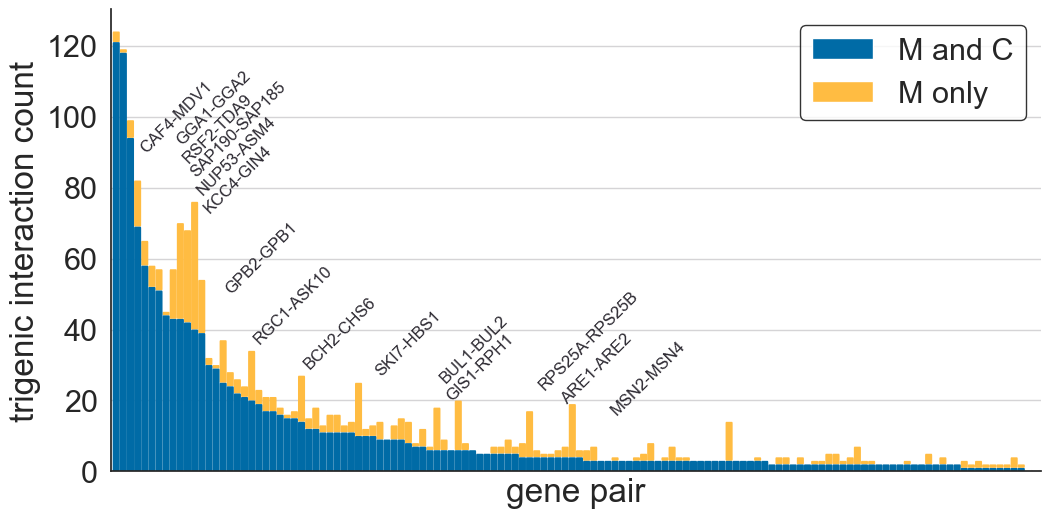

In [31]:
def get_gene_pairs(H):
    # for each edge in hypergraph, get the gene pairs it contains
    gene_pairs = defaultdict(int)
    for i in range(len(H.edges)):
        e = H.edges[i]
        # get all pairs within the 3-way edge
        # pairs = list(combinations(H.edges[e].elements.keys(), 2))
        pairs = list(combinations(e, 2))
        print(pairs)
        for i in pairs:
            gene_pairs[i] += 1
    
    # put these gene pair names, and the number of edges that contain them, in lists to make dataframes later on
    pair, num = [], []
    for k, v in sorted(gene_pairs.items(), key=lambda item: item[1], reverse=True):
        pair.append(k)
        num.append(v)
    return pair, num

gene_pairs_overlap, num_interactions_overlap = get_gene_pairs(H_overlap)
gene_pairs_mult, num_interactions_mult = get_gene_pairs(H_mult)

mult_pairs_df = pd.DataFrame.from_dict({"gene_pairs": gene_pairs_mult, "mult": num_interactions_mult})
overlap_pairs_df  = pd.DataFrame.from_dict({"gene_pairs": gene_pairs_overlap, "overlap": num_interactions_overlap})

pairs_df = overlap_pairs_df.merge(mult_pairs_df, how="outer")

pairs_df.loc[:, 'M only'] = pairs_df.mult - pairs_df.overlap
pairs_df.loc[:, 'only_mult_fraction'] = pairs_df['M only']/pairs_df.mult
pairs_df.loc[:, 'M and C'] = pairs_df.overlap
pairs_df = pairs_df[pairs_df.mult > 1]
pairs_df = pairs_df.sort_values(by='overlap', ascending=False)
pairs_df = pairs_df.astype({'gene_pairs':'str'})

pl = pairs_df[['M and C', 'M only']].plot.bar(stacked=True, color=[overlap_color, only_mult_color], width=1)
pl.figure.set_size_inches(4,4)
pl.set_xlabel('gene pair')
pl.set_ylabel('trigenic interaction count')

pl.figure.set_size_inches(12,6)
plt.rcParams.update({'font.size': 20})

# following code from: https://stackoverflow.com/questions/58425392/bar-chart-with-rounded-corners-in-matplotlib
new_patches = []
for patch in reversed(pl.patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.0040,rounding_size=0.1",
                        ec="none", fc=color,
                        mutation_aspect=4
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    pl.add_patch(patch)

plt.rcParams.update({'font.size': 12})
if dataset == "Kuzmin2020":
    #f"$\bf{label}$",
    # HIGHLIGHTING GENES WITH AT LEAST 10 ADDITIONAL M ONLY TRIGENIC INTERACTIONS
    pl.annotate("CAF4-MDV1", (3, 90), color="#2D2A32", rotation=45)    
    pl.annotate("GGA1-GGA2", (8, 92), color="#2D2A32", rotation=45)    
    pl.annotate("RSF2-TDA9", (9, 87), color="#2D2A32", rotation=45)    
    pl.annotate("SAP190-SAP185", (10, 83), color="#2D2A32", rotation=45)
    pl.annotate("NUP53-ASM4", (11, 78), color="#2D2A32", rotation=45)
    pl.annotate("KCC4-GIN4", (12, 73), color="#2D2A32", rotation=45)
    pl.annotate("GPB2-GPB1", (15, 50), color="#2D2A32", rotation=45)
    pl.annotate("RGC1-ASK10", (19, 36), color="#2D2A32", rotation=45)
    pl.annotate("BCH2-CHS6", (26, 29), color="#2D2A32", rotation=45)
    pl.annotate("SKI7-HBS1", (36, 27), color="#2D2A32", rotation=45)
    pl.annotate("BUL1-BUL2", (45, 25), color="#2D2A32", rotation=45)
    pl.annotate("GIS1-RPH1", (46, 20), color="#2D2A32", rotation=45)
    pl.annotate("RPS25A-RPS25B", (59, 23), color="#2D2A32", rotation=45)
    pl.annotate("ARE1-ARE2", (62, 19), color="#2D2A32", rotation=45)
    pl.annotate("MSN2-MSN4", (69, 16), color="#2D2A32", rotation=45) 
plt.rcParams.update({'font.size': 20})

pl.grid(visible=True, axis='y', alpha=0.2, color="#2D2A32")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False)
plt.legend(edgecolor="black")
sns.despine()
# plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/panels_tmp/trigen_count_barplot.pdf')

For the gene pairs highlighted in the above figure (Figure 4C in the manuscript), for the trigenic intractions that are unique to the multiplicative measure (M only), plot the fold enrichment of how often this third gene that participates in the trigenic interaction shares a GO annotation or protein-protein interaction with the genes in the original pair. This plot is Figure 4D in the manuscript.

/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_27573/978565505.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  only_mult_interactions = int(pairs_df[pairs_df.gene_pairs == f"(\'{gp[0]}\', \'{gp[1]}\')"]['M only'])


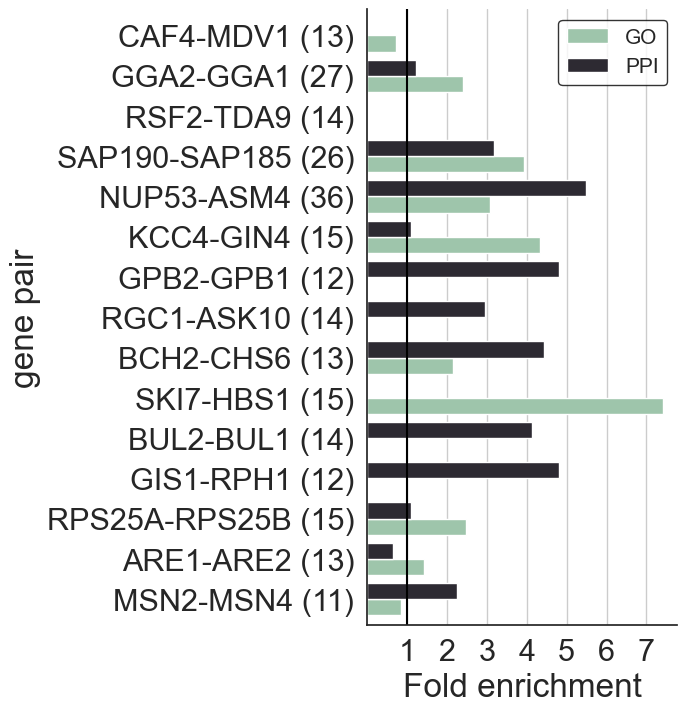

In [32]:
def PPIs_GO_fraction(df, gene_pairs, genome_wide_PPI, genome_wide_GO, pairs_df):
    # for each edge in hypergraph, get the gene pairs it contains

    groups = []
    group_labels = []

    for gp in gene_pairs:
        indices = []
        for i,r in df.iterrows():
            alleles = sorted(r['alleles'].split(","))
            alleles = [db.gene_stem_name(i.upper()) for i in alleles]
            if gp[0] in alleles and gp[1] in alleles:
                indices.append(i)
        tmp = df.filter(items=indices, axis=0)

        only_mult_interactions = int(pairs_df[pairs_df.gene_pairs == f"(\'{gp[0]}\', \'{gp[1]}\')"]['M only'])
        group_labels.append(f"{gp[0]}-{gp[1]} ({only_mult_interactions})")
        groups.append([(np.sum(tmp.threeway_shared_go)/len(tmp))/genome_wide_GO,
        (np.sum(tmp.three_shared_physical_interactions)/len(tmp))/genome_wide_PPI])

    tmp = pd.DataFrame(groups, index=group_labels)

        #results[f"{gp[0]}-{gp[1]}"] = [np.sum(tmp.three_shared_physical_interactions)/len(tmp),
        #                        np.sum(tmp.threeway_shared_go)/len(tmp)]
    return tmp

gene_pairs = [["CAF4","MDV1"],
                ["GGA2", "GGA1"],
                ["RSF2","TDA9"],
                ["SAP190", "SAP185"],
                ["NUP53", "ASM4"],
                ["KCC4","GIN4"],
                ["GPB2","GPB1"],
                ["RGC1", "ASK10"],
                ["BCH2", "CHS6"],
                ["SKI7", "HBS1"],
                ["BUL2", "BUL1"],
                ["GIS1", "RPH1"],
                ["RPS25A", "RPS25B"],
                ["ARE1", "ARE2"],
                ["MSN2", "MSN4"]]


genome_wide_GO = enrich.fraction_threeway_shared_go(df)['frac']
genome_wide_PPI = enrich.fraction_three_shared(df)['frac']

gene_pairs_PPI_GO = PPIs_GO_fraction(only_mult, gene_pairs, genome_wide_PPI, genome_wide_GO, pairs_df)
gene_pairs_PPI_GO = gene_pairs_PPI_GO.reset_index()
gene_pairs_PPI_GO = gene_pairs_PPI_GO.rename(columns={"index": "gene pair", 1:"PPI", 0:"GO"})
#gene_pairs_PPI_GO = gene_pairs_PPI_GO.sort_values(by='index', ascending=True)
gene_pairs_PPI_GO = gene_pairs_PPI_GO.sort_index(ascending=False)


#2D2A32
c = ["#9EC5AB", '#01200F']
c = ["#9EC5AB", '#2D2A32']
#c = ["#9EC5AB", '#806D40']

plt.rcParams.update({'font.size': 15})
pl = gene_pairs_PPI_GO.plot.barh(x="gene pair", color=c, width=0.8)
plt.xticks([1,2,3,4,5,6,7], ['1','2','3','4','5','6','7'])
plt.xlabel("Fold enrichment")
plt.grid(visible=True, axis='x', alpha=0.2, color="black")
legend_properties = {'size':15}
pl.legend(prop=legend_properties, loc='best', edgecolor="black")


pl.figure.set_size_inches(4,8)
pl.axvline(1, color="black")
#pl.axvline(enrich.fraction_three_shared(df)['frac'], color="red")
#pl.axvline(enrich.fraction_threeway_shared_go(df)['frac'], color="blue")
sns.despine()
# plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/panels_tmp/PPI_GO_selected_genes.pdf', bbox_inches = "tight")

For each paralog pair, compute the 'trigenic fraction', i.e. compare how many trigenic interactions they participate in to how many digenic interactions they participate in. We can do this for both the multiplicative and chimeric measures to compare (Figure S10).

106


/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bjarnold/miniforge3/envs/chimera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_

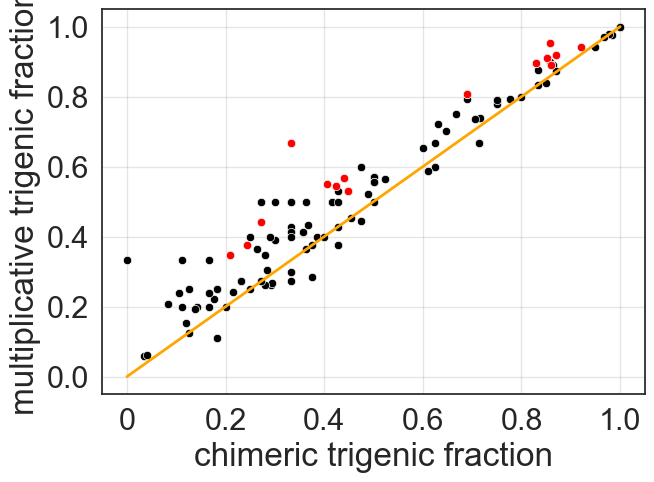

In [33]:
assert multiplicative == "tau_multiplicative2", "this cell only works under certain conditions!"

trigenic_fraction_mult, trigenic_fraction_chimeric = defaultdict(lambda : defaultdict(int)), defaultdict(lambda : defaultdict(int))

pval_trigenic = 0.05
pval_digenic = 0.05

for i,row in df[df.pval < pval_trigenic].iterrows():
    query_pair = f"{row['query1_allele_name']},{row['query2_allele_name']}"
    query_pair = query_pair.upper()
    
    trigenic_fraction_mult[query_pair]['trigenic'] += np.sum(row['tau_multiplicative2'] < tau_mult_sig_val['neg'])
    trigenic_fraction_mult[query_pair]['total'] += np.sum([row['tau_multiplicative2'] < tau_mult_sig_val['neg'],
                                                                (row['e_ik_mult2'] < 0.8945722886727014 and row['e_ik_kuz_pval'] < pval_digenic),
                                                                (row['e_jk_mult2'] < 0.8945722886727014 and row['e_jk_kuz_pval'] < pval_digenic)])

    trigenic_fraction_chimeric[query_pair]['trigenic'] += np.sum(row['adjusted_interaction_score_epsilon_or_tau'] < -0.08)
    trigenic_fraction_chimeric[query_pair]['total'] += np.sum([row['adjusted_interaction_score_epsilon_or_tau'] < -0.08,
                                                                (row['e_ik_kuz'] < -0.08 and row['e_ik_kuz_pval'] < pval_digenic),
                                                                (row['e_jk_kuz'] < -0.08 and row['e_jk_kuz_pval'] < pval_digenic)])

dict_for_df = defaultdict(list)
for query_pair in trigenic_fraction_mult:
    #use same filter as in Kuzmin 2020
    if trigenic_fraction_chimeric[query_pair]['total'] >= 6:
        dict_for_df['query_pair'].append(query_pair)
        dict_for_df['mult_trigenic'].append(trigenic_fraction_mult[query_pair]['trigenic'])
        dict_for_df['mult_total'].append(trigenic_fraction_mult[query_pair]['total'])
        dict_for_df['mult_fraction'].append( (trigenic_fraction_mult[query_pair]['trigenic']/trigenic_fraction_mult[query_pair]['total']) )

        dict_for_df['reported_trigenic'].append(trigenic_fraction_chimeric[query_pair]['trigenic'])
        dict_for_df['reported_total'].append(trigenic_fraction_chimeric[query_pair]['total'])
        dict_for_df['reported_fraction'].append( (trigenic_fraction_chimeric[query_pair]['trigenic']/trigenic_fraction_chimeric[query_pair]['total']) )

df_trigenic_fraction = pd.DataFrame.from_dict(dict_for_df)

# get just gene pairs that are highlighted in figure 2
gene_pairs_selected = [f"{g[0]},{g[1]}" for g in gene_pairs]
df_trigenic_fraction_selected = df_trigenic_fraction[df_trigenic_fraction['query_pair'].isin(gene_pairs_selected)]

fig = plt.figure(figsize=(7,5))
sns.scatterplot(x=df_trigenic_fraction['reported_fraction'], y=df_trigenic_fraction['mult_fraction'], color="black")
sns.scatterplot(x=df_trigenic_fraction_selected['reported_fraction'], y=df_trigenic_fraction_selected['mult_fraction'], color="red")

plt.plot([0, 1], [0, 1], linewidth=2, color="orange")
plt.xlabel("chimeric trigenic fraction")
plt.ylabel("multiplicative trigenic fraction")
plt.grid(visible=True, axis='both', alpha=0.2, which='both', color="gray")
plt.xticks([0,0.2,0.4,0.6,0.8,1.0], ['0','0.2','0.4','0.6','0.8','1.0'])

tmp = df_trigenic_fraction[(abs(df_trigenic_fraction['reported_fraction'] - df_trigenic_fraction['mult_fraction']) >= 0)]
print(len(tmp))

# plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/trigenic_fractions.pdf', bbox_inches = "tight")



The following code makes was used to make Figure 4E in the manuscript, in which we study the GO terms of genes that have trigenic interactions with the NUP53-ASM4 paralog pair. For each of these genes, we color them according to whether they were uniquely detected by the multiplicative formula (orange) or also calculated by the chimeric formula (dark blue). We also arrange them spatially so that genes in the same GO category are close to each other.

The rest of the annotations for that figure panel were manually added in Powerpoint.

/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_27573/669476009.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


36
36
36


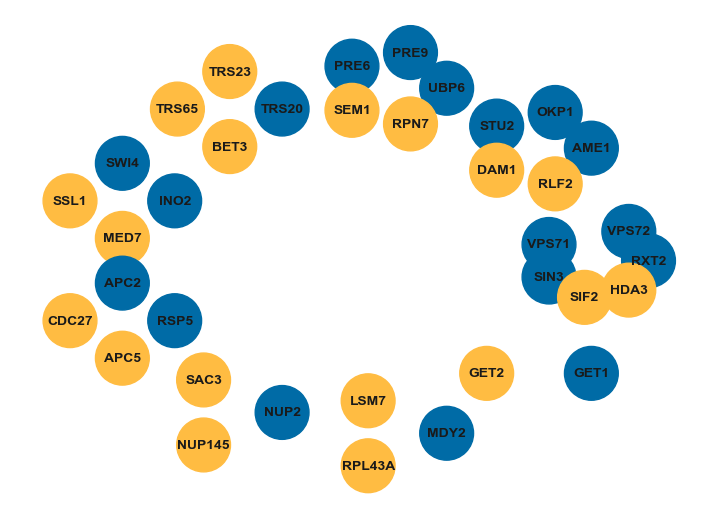

In [34]:

def categorize_third_genes(overlap, only_mult, gene1, gene2, selected_go_complexes):
    third_genes = []
    def f(df, color):
        for i,r in df.iterrows():
            a = r['alleles'].split(',')
            a = tuple([i.split('-')[0].upper() for i in a])
            if gene1 in a and gene2 in a:
                third_gene = [i for i in a if i not in [gene1,gene2]][0]
                third_genes.append( (third_gene,color) )

    f(overlap, overlap_color)
    f(only_mult, only_mult_color)

    # categorize genes by GO complex
    GO_complexes = defaultdict(list)
    for gene in third_genes:
        if gene[0] in gene_2_protein_complex:
            for go in gene_2_protein_complex[gene[0]]:
                GO_complexes[go].append(gene)

    G = nx.Graph()
    node_attr = defaultdict(list)
    for go in selected_go_complexes:
        for gene in GO_complexes[go]:
            if gene[0] not in G.nodes():
                node_attr['size'].append(1500)
                node_attr['color'].append(gene[1])
                G.add_node(gene[0])
    
    return  G, node_attr, GO_complexes


selected_go_complexes = ["chromatin", 
                            "chromosome, centromeric region", 
                            "proteasome complex", 
                            "TRAPP complex", 
                            "RNA polymerase II transcription factor complex", 
                            "ubiquitin ligase complex", 
                            "nuclear pore",
                            "intracellular ribonucleoprotein complex",
                            "GET complex"]

G_nup_asm, node_attr, GO_complexes =  categorize_third_genes(overlap, only_mult, 'NUP53', 'ASM4', selected_go_complexes)


rad_big = 7 # this is the radius along which protein complexe clusters are plotted
rad_small = 1.5 # this is the radius within each protein complex cluster
centroid_angs = np.linspace(0, 2*np.pi, 1+len(selected_go_complexes)) 
# go through each set of genes by pathway

# go thru each pathway in nup53_asm4_select_complexes
# get set of genes in GO_complexes
# divide 2*np.pi by # genes, or use linspace to get evenly spaces points
# go through indices of genes, assigning it location based on index in linspace list

pos = {}
for i,complex in enumerate(selected_go_complexes):
    genes = GO_complexes[complex]
    node_angs =  np.linspace(0, 2*np.pi, 1+len(genes)) 
    centroid_ang = centroid_angs[i]
    for i,gene in enumerate(genes):
        node_ang = node_angs[i]
        pos[gene[0]] = np.array([rad_big*np.cos(centroid_ang)+rad_small*np.cos(node_ang),
                                rad_big*np.sin(centroid_ang)+rad_small*np.sin(node_ang)])

print(len(G_nup_asm.nodes()))
print(len(pos.keys()))
print(len(node_attr['color']))

plt.figure(figsize=(7,5))

pl = nx.draw(G_nup_asm, pos, 
        with_labels=True,
        node_color=node_attr['color'],
        node_size=node_attr['size'],
        font_size=10, 
        font_weight='bold')

# prevent nodes from getting cut off at edges
plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.1*x for x in axis.get_xlim()])
axis.set_ylim([1.1*y for y in axis.get_ylim()])


plt.tight_layout()
# plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/panels_tmp/nup53_asm4.pdf', transparent=True)


We repeat this analysis for the SKI7-HBS1 paralog pair.

(-0.17114566456956687, 0.9540589559609042)

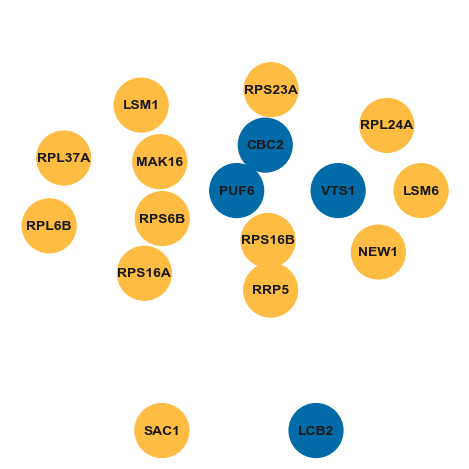

In [35]:
selected_go_complexes = ["intracellular ribonucleoprotein complex", 
                            "SPOTS complex"]

G_ski_hbs, node_attr, GO_complexes =  categorize_third_genes(overlap, only_mult, 'SKI7', 'HBS1', selected_go_complexes)

def rtpairs(r, n, offset):
    pos = []
    for i in range(len(r)):
        angs = np.linspace(0, 2*np.pi, n[i]+1)
        angs = angs[0:-1]
        for j in angs:    
            jitter = np.random.uniform(low=0.95,high=1.05)
            pos.append(np.array( [offset[0] + r[i]*jitter*(np.cos(j)), 
                                offset[1] + r[i]*jitter*(np.sin(j))] ))
    return(pos)

pos = {}
# 15 genes in this complex
N = [1, 5, 9] 
R = [0, 0.125, 0.25]
pos_tmp = rtpairs(R, N, [0,0.5])

for i,gene in enumerate(GO_complexes["intracellular ribonucleoprotein complex"]):
    pos[gene[0]] = pos_tmp[i]

N = [2] 
R = [0.1]
pos_tmp = rtpairs(R, N, [0,-0.1])
for i,gene in enumerate(GO_complexes["SPOTS complex"]):
    pos[gene[0]] = pos_tmp[i]


fig = plt.figure(figsize=(4.5,4.5))
pl = nx.draw(G_ski_hbs, pos, 
        with_labels=True,
        node_color=node_attr['color'],
        node_size=node_attr['size'],
        font_size=10, 
        font_weight='bold')
# prevent nodes from getting cut off at edges
plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.1*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
# plt.savefig('/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/figs/panels_tmp/ski7_hbs1.pdf', transparent=True)